# Census income classification with Keras

To download a copy of this notebook visit [github](https://github.com/shap/shap/tree/master/notebooks).

In [3]:
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    concatenate,
    Embedding
)
from keras.models import Model
from sklearn.model_selection import train_test_split

from keras.models import Model
from sklearn.model_selection import train_test_split

import shap

import matplotlib.pyplot as plt

# print the JS visualization code to the notebook
shap.initjs()

## Load dataset

In [5]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k, dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=7
)

## Train Keras model

In [7]:
# build model
input_els = []
encoded_els = []
for k, dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max() + 1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)

# train model
regression = Model(inputs=input_els, outputs=[out])
regression.compile(optimizer="adam", loss="binary_crossentropy")
regression.fit(
    [X_train[k].values for k, t in dtypes],
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k, t in dtypes], y_valid),
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9519 - val_loss: 0.5382
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4985 - val_loss: 0.5509
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3390 - val_loss: 0.5798
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2577 - val_loss: 0.5328
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2183 - val_loss: 0.5952
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2021 - val_loss: 0.5502
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1569 - val_loss: 0.5424
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0788 - val_loss: 0.4994
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9593 - val_loss: 0.5438
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0220 - val_loss: 0.4498
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8706 - val_loss: 0.4377
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7889 - val_lo

## Explain predictions

Here we take the Keras model trained above and explain why it makes different predictions for different individuals. SHAP expects model functions to take a 2D numpy array as input, so we define a wrapper function around the original Keras predict function.

In [9]:
def f(X):
    return regression.predict([X[:, i] for i in range(X.shape[1])]).flatten()

### Explain a single prediction

Here we use a selection of 50 samples from the dataset to represent "typical" feature values, and then use 500 perterbation samples to estimate the SHAP values for a given prediction. Note that this requires 500 * 50 evaluations of the model.

In [11]:
X.iloc[299, :]

Age               -0.042641
Workclass          4.000000
Education-Num     -0.420053
Marital Status     0.000000
Occupation        12.000000
Relationship       0.000000
Race               4.000000
Sex                1.000000
Capital Gain      -0.145918
Capital Loss      -0.216656
Hours per week     3.204112
Country           39.000000
Name: 299, dtype: float64

In [12]:
X.iloc[299:300, :]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
299,-0.042641,4,-0.420053,0,12,0,4,1,-0.145918,-0.216656,3.204112,39


In [13]:
 X.iloc[:50, :]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0.030670,7,1.134722,4,1,0,4,1,0.148451,-0.216656,-0.035429,39
1,0.837096,6,1.134722,2,4,4,4,1,-0.145918,-0.216656,-2.222119,39
2,-0.042641,4,-0.420053,0,6,0,4,1,-0.145918,-0.216656,-0.035429,39
3,1.057031,4,-1.197440,2,6,4,2,1,-0.145918,-0.216656,-0.035429,39
4,-0.775756,4,1.134722,2,10,5,2,0,-0.145918,-0.216656,-0.035429,5
5,-0.115953,4,1.523415,2,4,5,4,0,-0.145918,-0.216656,-0.035429,39
6,0.763785,4,-1.974828,3,8,0,2,0,-0.145918,-0.216656,-1.979153,23
7,0.983719,6,-0.420053,2,4,4,4,1,-0.145918,-0.216656,0.369514,39
8,-0.555822,4,1.523415,4,10,0,4,0,1.761115,-0.216656,0.774456,39
9,0.250605,4,1.134722,2,4,4,4,1,0.555205,-0.216656,-0.035429,39


In [14]:
kernel_explainer = shap.KernelExplainer(f, X.iloc[:50, :])
shap_values = kernel_explainer.shap_values(X.iloc[299, :], nsamples=500)

shap.force_plot(kernel_explainer.expected_value, shap_values, X_display.iloc[299, :])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [15]:
shap_values =kernel_explainer(X.iloc[299:300, :])

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [16]:
shap_values

.values =
array([[ 0.01960378,  0.00140661, -0.03165575, -0.03832163,  0.02884433,
        -0.1421984 ,  0.00247395,  0.01089446, -0.03158654, -0.00593973,
         0.18868307,  0.00430324]])

.base_values =
array([0.2541085])

.data =
array([[-0.04264132,  4.        , -0.42005304,  0.        , 12.        ,
         0.        ,  4.        ,  1.        , -0.14591824, -0.21665621,
         3.20411205, 39.        ]])

In [17]:
kernel_explainer.expected_value

0.2541084971278906

In [18]:
shap_values

.values =
array([[ 0.01960378,  0.00140661, -0.03165575, -0.03832163,  0.02884433,
        -0.1421984 ,  0.00247395,  0.01089446, -0.03158654, -0.00593973,
         0.18868307,  0.00430324]])

.base_values =
array([0.2541085])

.data =
array([[-0.04264132,  4.        , -0.42005304,  0.        , 12.        ,
         0.        ,  4.        ,  1.        , -0.14591824, -0.21665621,
         3.20411205, 39.        ]])

In [19]:
partition_tree = {
    'cluster_16': {
        'cluster_12': {
            'cluster_8': {'Age': 'Age', 'Workclass': 'Workclass'},
            'cluster_9': {'Education-Num': 'Education-Num', 'Marital Status': 'Marital Status'}
        },
        'cluster_13': {
            'cluster_10': {'Occupation': 'Occupation', 'Relationship': 'Relationship'},
            'cluster_11': {'Race': 'Race', 'Sex': 'Sex'}
        }
    },
    'cluster_17': {
        'cluster_14': {'Capital Gain': 'Capital Gain', 'Capital Loss': 'Capital Loss'},
        'cluster_15': {'Hours per week': 'Hours per week', 'Country': 'Country'}
    }
}

partition_tree = {
    'cluster_16': {
            'cluster_8': {'Age': 'Age', 'Race': 'Race', 'Sex': 'Sex'},
        },
        'cluster_13': {
            'cluster_10': {'Occupation': 'Occupation', 'Hours per week': 'Hours per week','Relationship': 'Relationship','Education-Num': 'Education-Num'},
            'cluster_14': {'Capital Gain': 'Capital Gain', 'Capital Loss': 'Capital Loss','Country': 'Country'}
        }
}
partition_masker = shap.maskers.Partition(X.iloc[:50, :])

explainer = shap.explainers.Partition(f, partition_masker, partition_tree=partition_tree)
row_to_explain = X.iloc[299:300, :]
winter_values = explainer(row_to_explain)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

In [20]:
shap_values

.values =
array([[ 0.01960378,  0.00140661, -0.03165575, -0.03832163,  0.02884433,
        -0.1421984 ,  0.00247395,  0.01089446, -0.03158654, -0.00593973,
         0.18868307,  0.00430324]])

.base_values =
array([0.2541085])

.data =
array([[-0.04264132,  4.        , -0.42005304,  0.        , 12.        ,
         0.        ,  4.        ,  1.        , -0.14591824, -0.21665621,
         3.20411205, 39.        ]])

In [21]:
winter_values

.values =
array([[ 0.01617414,  0.        , -0.03043876,  0.        ,  0.02902471,
        -0.14485905,  0.00220634,  0.00977516, -0.03081214, -0.00764494,
         0.19120987,  0.00473149]])

.base_values =
array([0.2541085])

.data =
array([[-0.04264132,  4.        , -0.42005304,  0.        , 12.        ,
         0.        ,  4.        ,  1.        , -0.14591824, -0.21665621,
         3.20411205, 39.        ]])

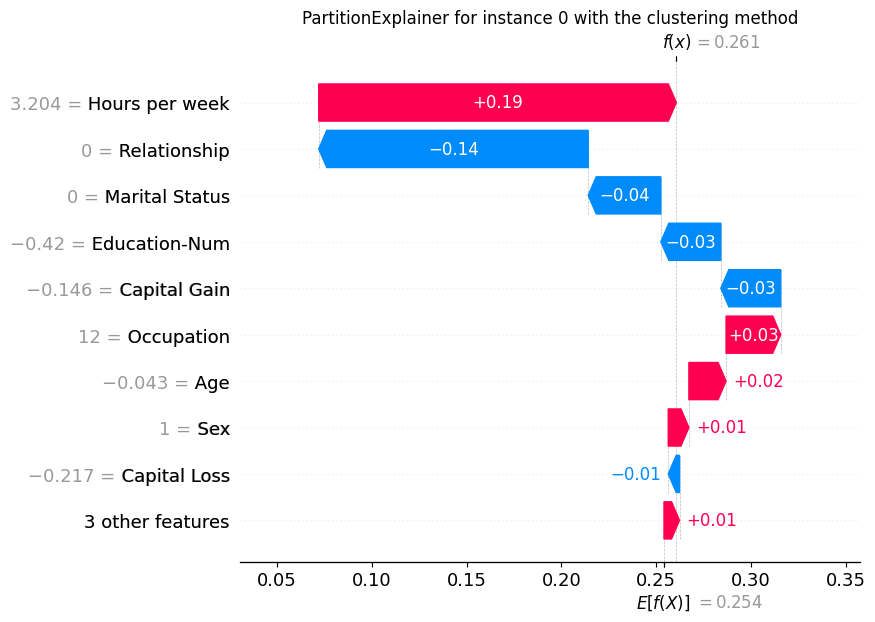

In [22]:
fig, ax = plt.subplots()
shap.plots.waterfall(shap_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

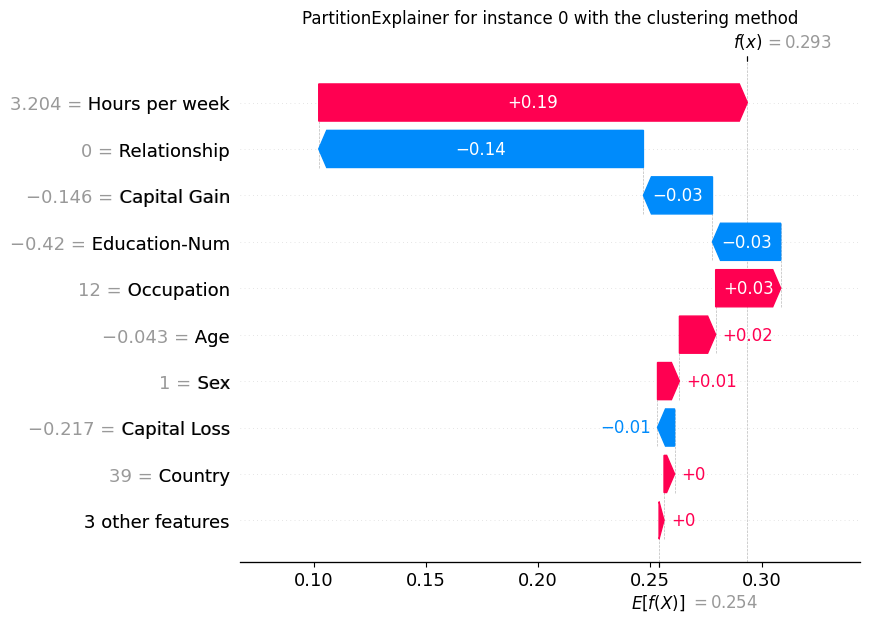

In [23]:
fig, ax = plt.subplots()
shap.plots.waterfall(winter_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

In [24]:
shap.force_plot(winter_values.base_values, winter_values.values, X_display.iloc[299:300, :])

In [25]:
shap_values

.values =
array([[ 0.01960378,  0.00140661, -0.03165575, -0.03832163,  0.02884433,
        -0.1421984 ,  0.00247395,  0.01089446, -0.03158654, -0.00593973,
         0.18868307,  0.00430324]])

.base_values =
array([0.2541085])

.data =
array([[-0.04264132,  4.        , -0.42005304,  0.        , 12.        ,
         0.        ,  4.        ,  1.        , -0.14591824, -0.21665621,
         3.20411205, 39.        ]])

### Explain many predictions

Here we repeat the above explanation process for 50 individuals. Since we are using a sampling based approximation each explanation can take a couple seconds depending on your machine setup.

In [27]:
winter_values50 = explainer(X.iloc[280:330, :])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:   8%|▊         | 4/50 [00:24<03:08,  4.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  10%|█         | 5/50 [00:33<04:21,  5.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:41<04:55,  6.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:49<05:11,  7.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  16%|█▌        | 8/50 [00:57<05:17,  7.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━

PartitionExplainer explainer:  18%|█▊        | 9/50 [01:05<05:17,  7.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  20%|██        | 10/50 [01:14<05:17,  7.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  22%|██▏       | 11/50 [01:22<05:13,  8.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  24%|██▍       | 12/50 [01:30<05:06,  8.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:38<04:58,  8.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  28%|██▊       | 14/50 [01:46<04:51,  8.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━

PartitionExplainer explainer:  30%|███       | 15/50 [01:54<04:44,  8.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  32%|███▏      | 16/50 [02:03<04:38,  8.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  34%|███▍      | 17/50 [02:11<04:33,  8.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  36%|███▌      | 18/50 [02:20<04:25,  8.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  38%|███▊      | 19/50 [02:28<04:16,  8.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  40%|████      | 20/50 [02:36<04:07,  8.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  42%|████▏     | 21/50 [02:44<03:58,  8.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  44%|████▍     | 22/50 [02:52<03:49,  8.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━

PartitionExplainer explainer:  46%|████▌     | 23/50 [03:01<03:42,  8.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  48%|████▊     | 24/50 [03:09<03:34,  8.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  50%|█████     | 25/50 [03:17<03:26,  8.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  52%|█████▏    | 26/50 [03:25<03:17,  8.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  54%|█████▍    | 27/50 [03:34<03:08,  8.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  56%|█████▌    | 28/50 [03:42<03:00,  8.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  58%|█████▊    | 29/50 [03:50<02:51,  8.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━

PartitionExplainer explainer:  60%|██████    | 30/50 [03:58<02:43,  8.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  62%|██████▏   | 31/50 [04:06<02:36,  8.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━

PartitionExplainer explainer:  64%|██████▍   | 32/50 [04:15<02:28,  8.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━

PartitionExplainer explainer:  66%|██████▌   | 33/50 [04:23<02:20,  8.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━

PartitionExplainer explainer:  68%|██████▊   | 34/50 [04:31<02:12,  8.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  70%|███████   | 35/50 [04:39<02:03,  8.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  72%|███████▏  | 36/50 [04:48<01:55,  8.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  74%|███████▍  | 37/50 [04:56<01:47,  8.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  76%|███████▌  | 38/50 [05:04<01:38,  8.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  78%|███████▊  | 39/50 [05:12<01:30,  8.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━

PartitionExplainer explainer:  80%|████████  | 40/50 [05:21<01:22,  8.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  82%|████████▏ | 41/50 [05:29<01:14,  8.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  84%|████████▍ | 42/50 [05:37<01:05,  8.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  86%|████████▌ | 43/50 [05:45<00:57,  8.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

PartitionExplainer explainer:  88%|████████▊ | 44/50 [05:54<00:49,  8.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  90%|█████████ | 45/50 [06:02<00:41,  8.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━

PartitionExplainer explainer:  92%|█████████▏| 46/50 [06:10<00:32,  8.19s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer:  94%|█████████▍| 47/50 [06:18<00:24,  8.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━

PartitionExplainer explainer:  96%|█████████▌| 48/50 [06:26<00:16,  8.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━

PartitionExplainer explainer:  98%|█████████▊| 49/50 [06:34<00:08,  8.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━

PartitionExplainer explainer: 100%|██████████| 50/50 [06:43<00:00,  8.19s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

PartitionExplainer explainer: 51it [06:51,  8.39s/it]                        


In [28]:
shap_values50 = kernel_explainer.shap_values(X.iloc[280:330, :], nsamples=500)
shap.force_plot(kernel_explainer.expected_value, shap_values50, X_display.iloc[280:330, :])

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
782/782 ━━━━━━

In [29]:
shap.force_plot(kernel_explainer.expected_value, shap_values50, X_display.iloc[280:330, :])

In [30]:
shap.force_plot(winter_values50.base_values, winter_values50.values, X_display.iloc[280:330, :])